# Get Data


In [3]:
############################# Import Statements ##############################

#fileio imports
from io import BytesIO
import urllib.request
import tarfile
import nltk

#basic imports
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#preprocessing imports
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import os,re,string
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS

#model imports 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, f1_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten, Bidirectional, GlobalMaxPool1D,  Convolution1D
from keras.models import Model, Sequential

#interactive imports
import requests
from bs4 import BeautifulSoup
import itertools
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [4]:
#the file is huge so this takes a little bit of time to get all the data 
#we read in the zipped file using ftpstream and bytesio 
tarfile_url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
ftpstream = urllib.request.urlopen(tarfile_url)

tmpfile = BytesIO()
while True:
    s = ftpstream.read(16384)
    if not s: break
    tmpfile.write(s)
ftpstream.close()

#we seek to the root of the file we just got 
tmpfile.seek(0)

tfile = tarfile.open(fileobj=tmpfile, mode="r:gz")

#we find all the files that have pos or neg in their path (these are the text files we want)
pos_review_filenames = [filename for filename in tfile.getnames() if "/pos/" in filename]
neg_review_filenames = [filename for filename in tfile.getnames() if "/neg/" in filename]

#now we simply read in the text from each file and append it into our arrays
pos = []
for filename in pos_review_filenames:
    review_stream = tfile.extractfile(filename)
    pos.append(review_stream.read())
    
neg = []
for filename in neg_review_filenames:
    review_stream = tfile.extractfile(filename)
    neg.append(review_stream.read())

#don't forget to close the streams and readers!!
tfile.close()
tmpfile.close()

In [5]:
print("number of positive reviews" + str(len(pos)))
print("number of negative reviews" + str(len(neg)))

display(pos[1])
display(neg[1])

number of positive reviews25000
number of negative reviews25000


b'CONTAINS "SPOILER" INFORMATION. Watch this director\'s other film, "Earth", at some point. It\'s a better film, but this one isn\'t bad just different.<br /><br />A rare feminist point of view from an Indian filmmaker. Tradition, rituals, duty, secrets, and the portrayal of strict sex roles make this an engaging and culturally dynamic film viewing experience. All of the married characters lack the "fire" of the marriage bed with their respective spouses. One husband is celibate and commits a form of spiritual "adultery" by giving all of his love, honor, time and respect to his religious swami (guru). His wife is lonely and yearns for intimacy and tenderness which she eventually finds with her closeted lesbian sister-in-law who comes to live in their house with her unfaithful husband. This unfaithful husband is openly in love with his Chinese mistress but was forced into marriage with a (unbeknownest to him) lesbian. They only have sex once when his closet lesbian wife loses her virgi

b"Worth the entertainment value of a rental, especially if you like action movies. This one features the usual car chases, fights with the great Van Damme kick style, shooting battles with the 40 shell load shotgun, and even terrorist style bombs. All of this is entertaining and competently handled but there is nothing that really blows you away if you've seen your share before.<br /><br />The plot is made interesting by the inclusion of a rabbit, which is clever but hardly profound. Many of the characters are heavily stereotyped -- the angry veterans, the terrified illegal aliens, the crooked cops, the indifferent feds, the bitchy tough lady station head, the crooked politician, the fat federale who looks like he was typecast as the Mexican in a Hollywood movie from the 1940s. All passably acted but again nothing special.<br /><br />I thought the main villains were pretty well done and fairly well acted. By the end of the movie you certainly knew who the good guys were and weren't. Th

# Pre Processing



In [6]:
pos = pos[0:5000]
neg = neg[0:5000]

In [7]:
random_state = 530
#split up the training and test sets for both positive and negative reviews 

#this is the labels of all the positive reviews 
sentiment_pos = [1]*len(pos)
#we split the positive dataset into reviews training and test
review_p_train, review_p_test, sentiment_p_train, sentiment_p_test = train_test_split(pos, sentiment_pos, test_size=1000, random_state=random_state)

#this is the labels of all the negative reviews
sentiment_neg = [0]*len(neg)
#we split the negative dataset into reviews training and test
review_n_train, review_n_test, sentiment_n_train, sentiment_n_test = train_test_split(neg, sentiment_neg, test_size=1000, random_state=random_state)

#lets just make sure we are splitting as we want! 
print(len(review_p_train), len(review_p_test), len(sentiment_p_train), len(sentiment_p_test) )
print(len(review_n_train), len(review_n_test), len(sentiment_n_train), len(sentiment_n_test) )


4000 1000 4000 1000
4000 1000 4000 1000


In [8]:
#a bunch of basic preprocessing like removing noise, special characters
def denoise_text(text):
    #strips html away 
    text = BeautifulSoup(text, "html.parser")
    #removes square brackets 
    text = re.sub('\[[^]]*\]', '', str(text))
    #removes special characters
    pattern=r'[^a-zA-z0-9\s]'
    text = re.sub(pattern,'',str(text))
    return text

#Apply function to every review 
review_p_train = list(map(denoise_text, review_p_train))
review_n_train = list(map(denoise_text, review_n_train))
review_p_test = list(map(denoise_text, review_p_test))
review_n_test = list(map(denoise_text, review_n_test))

In [9]:
#Stemming the text
def stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

#Apply function to every review 
review_p_train = list(map(stemmer, review_p_train))
review_n_train = list(map(stemmer, review_n_train))
review_p_test = list(map(stemmer, review_p_test))
review_n_test = list(map(stemmer, review_n_test))

In [10]:
nltk.download("stopwords")

#Tokenization of text
tokenizer = ToktokTokenizer()
#Get the stopwords in english
stopword_list = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
#set stopwords to english
stop = set(stopword_list)
#lets look at some of the stop words
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

#Apply function to every review 
review_p_train = list(map(remove_stopwords, review_p_train))
review_n_train = list(map(remove_stopwords, review_n_train))
review_p_test = list(map(remove_stopwords, review_p_test))
review_n_test = list(map(remove_stopwords, review_n_test))

{'the', 'am', 'from', 'up', 'down', 'now', 'he', 'each', 'no', 'should', 'me', 'an', 'most', 'her', 'so', 'needn', 'any', 'in', 'out', 'both', 'my', 'will', 'haven', 'had', 'how', 'over', 'few', 'hasn', 's', "couldn't", "shouldn't", 'other', 'wasn', 'once', 'him', 'their', 'nor', "you'll", 'where', "mustn't", 'o', 'very', "you'd", 'do', 'with', 'himself', 'hadn', "isn't", 'between', "you've", 'why', 'they', 'if', 'than', 'but', 'ma', 'through', 'his', "aren't", 'and', 'ourselves', 'are', 'during', "mightn't", 'did', 't', 'yourself', 'd', 'there', 'our', 'some', 'them', "wouldn't", 'mustn', 'don', 'were', 'mightn', 'its', 'being', 'shouldn', 'not', 'here', 'won', "haven't", 'all', "shan't", 'it', 'before', "doesn't", 'own', 'after', 'weren', 'these', "should've", 'yourselves', 'itself', 'to', 'doing', "don't", 'further', 'ain', "needn't", 'same', 'yours', 'does', "she's", 've', 'under', 'off', 'while', 'against', 'll', "it's", 'below', 'myself', 'such', 'ours', 'for', 'who', 'shan', 'sh

In [12]:
# pretty much done the preprocessing and cleaning lets check it out
# we can still do more removal 
print(review_p_train[1])
print(review_p_test[1])
print(review_n_train[1])
print(review_n_test[1])

yeah great cult TV seri great atmospher top script good perform make thi class candid dvd releas brbrthi semin tour de forc australian TV histori ha unforgett groovi period piec soundtrack doug parkinson gravel phlegm voic spew 70 australiana cathod ray box amazingli long camera zoom reveal religion open road antipodean glori thi memento anoth distant era ha proud stamp land mighti start finish raw freedom gritti grandeur brbrcome abc get program releas thi cool 70 cult babi enjoy reenjoy lucki enough live dream time
thi oscarwin short film 40 minut base short stori william faulkner take us back smalltown tennesse decemb 1941 two brother one 18 one 8 look bird egg obvious huge collector item boy south around thi time well japanes bomb pearl harbor older brother pete decid enlist give hi prize egg hi littl brother willi head wish show emot tender hi littl acolyt well willi isnt ani pete soldier head memphi show hi stubborn determin get better sever adult along way find enlist center mem

<function matplotlib.pyplot.show>

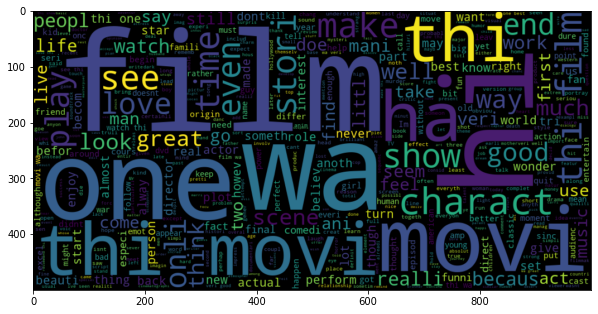

In [13]:
plt.figure(figsize=(10,10))
pos_text = (" ").join(review_p_train)

wc = WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words = wc.generate(pos_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

<function matplotlib.pyplot.show>

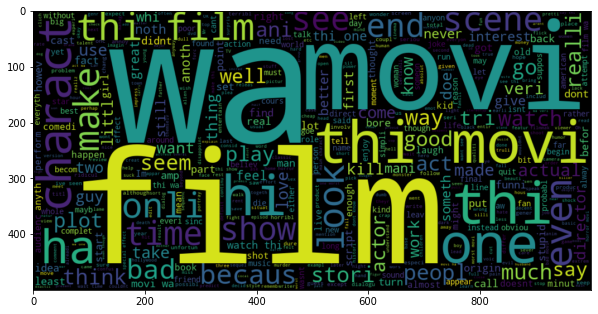

In [14]:
plt.figure(figsize=(10,10))
pos_text = (" ").join(review_n_train)

wc = WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words = wc.generate(pos_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

# Models

Here we are going to use three types of representations. The first will be a sparse bag of word matrix representation, the second is an ngram based bag of words model, and the final is a term frequency document model. All three will be using a custom tokenize function that I have written in order to improve the accuracy of the CountVectorizer function. 

In [15]:
#custom tokenizer function
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

#Count Vectorizer for sparse bag of words model 
sparse = CountVectorizer(tokenizer=tokenize)

#transformed train reviews 
sparse_train_reviews = sparse.fit_transform(review_p_train + review_n_train)

#transformed test reviews
sparse_test_reviews = sparse.transform(review_p_test + review_n_test)

print('len, sparse features:', sparse_train_reviews.shape)
print('len, sparse features:', sparse_test_reviews.shape)

len, sparse features: (8000, 53417)
len, sparse features: (2000, 53417)


In [16]:
#Count vectorizer for bag of words model using 7-grams
cv = CountVectorizer(ngram_range=(1,7), tokenizer=tokenize, max_features=53417)

#transformed train reviews
cv_train_reviews = cv.fit_transform(review_p_train + review_n_train)

#transformed test reviews
cv_test_reviews = cv.transform(review_p_test + review_n_test)

print('len, BOW features:', cv_train_reviews.shape)
print('len, BOW features:', cv_test_reviews.shape)

len, BOW features: (8000, 53417)
len, BOW features: (2000, 53417)


In [17]:
#Let us now create a term frequency document instead of BOW 
tf=TfidfVectorizer(use_idf=True,ngram_range=(1,7), tokenizer=tokenize,  max_features=53417)

#transformed train reviews
tf_train_reviews = tf.fit_transform(review_p_train + review_n_train)

#transformed test reviews
tf_test_reviews = tf.transform(review_p_test + review_n_test)

print('len, tfidf features:', tf_train_reviews.shape)
print('len, tfidf features:', tf_test_reviews.shape)

len, tfidf features: (8000, 53417)
len, tfidf features: (2000, 53417)


## Logistic Regression


In [18]:
# hyperparamter tuning for logistic regression 
from sklearn.model_selection import GridSearchCV

model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# Here we start the grid search 
grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid_search_1 = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, scoring='accuracy',error_score=0)
grid_search_2 = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, scoring='accuracy',error_score=0)
grid_search_3 = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, scoring='accuracy',error_score=0)

grid_result_1 = grid_search_1.fit(sparse_train_reviews, sentiment_p_train + sentiment_n_train)
print("Best Sparse: %f using %s" % (grid_result_1.best_score_, grid_result_1.best_params_))
grid_result_2 = grid_search_2.fit(cv_train_reviews, sentiment_p_train + sentiment_n_train)
print("Best BOW ngram: %f using %s" % (grid_result_2.best_score_, grid_result_2.best_params_))
grid_result_3 = grid_search_3.fit(tf_train_reviews, sentiment_p_train + sentiment_n_train)
print("Best tfidf: %f using %s" % (grid_result_3.best_score_, grid_result_3.best_params_))

Best Sparse: 0.877000 using {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
Best BOW ngram: 0.882500 using {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best tfidf: 0.897250 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


In [19]:
#training the logistic regression model 
lr_1 = LogisticRegression(C=0.1,random_state=31,solver='newton-cg')
lr_2 = LogisticRegression(C=0.1,random_state=31,solver='liblinear')
lr_3 = LogisticRegression(C=0.1,random_state=31,solver='newton-cg')

#Fitting the model for sparse BOW 
lr_sparse = lr_1.fit(sparse_train_reviews, sentiment_p_train + sentiment_n_train)
print(lr_sparse)

#Fitting the model for BOW
lr_bow = lr_2.fit(cv_train_reviews, sentiment_p_train + sentiment_n_train)
print(lr_bow)

#Fitting the model for tfidf features
lr_tfidf = lr_3.fit(tf_train_reviews,sentiment_p_train+sentiment_n_train)
print(lr_tfidf)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=31, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=31, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=31, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)


In [20]:
#Predicting the logistitc regression model for sparse bag of words
lr_sparse_predict = lr_sparse.predict(sparse_test_reviews)
print(lr_sparse_predict)

#Predicting the logistic regression model for bag of words
lr_bow_predict = lr_bow.predict(cv_test_reviews)
print(lr_bow_predict)

##Predicting the logistic regression model for tfidf features
lr_tfidf_predict = lr_tfidf.predict(tf_test_reviews)
print(lr_tfidf_predict)

[1 1 1 ... 0 0 0]
[1 1 1 ... 0 0 0]
[1 1 1 ... 1 0 0]


In [21]:
# lets gets some reports on how we did 

#Accuracy score for sparse bag of words
lr_sparse_score=accuracy_score(sentiment_p_test + sentiment_n_test,lr_sparse_predict)
print("Logistic Regression with BOW accuracy: ",lr_sparse_score)

#Classification report for sparse bag of words 
lr_sparse_report=classification_report(sentiment_p_test + sentiment_n_test, lr_sparse_predict,target_names=['Positive','Negative'])
print(lr_sparse_report)

#Accuracy score for bag of words
lr_bow_score=accuracy_score(sentiment_p_test + sentiment_n_test,lr_bow_predict)
print("Logistic Regression with BOW accuracy: ",lr_bow_score)

#Classification report for bag of words 
lr_bow_report=classification_report(sentiment_p_test + sentiment_n_test, lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)

#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(sentiment_p_test + sentiment_n_test,lr_tfidf_predict)
print("Logisitic Regression with TFIDF accuracy: ",lr_tfidf_score)

#Classification report for tfidf features
lr_tfidf_report=classification_report(sentiment_p_test + sentiment_n_test,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

Logistic Regression with BOW accuracy:  0.8835
              precision    recall  f1-score   support

    Positive       0.90      0.86      0.88      1000
    Negative       0.87      0.91      0.89      1000

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000

Logistic Regression with BOW accuracy:  0.8895
              precision    recall  f1-score   support

    Positive       0.91      0.87      0.89      1000
    Negative       0.87      0.91      0.89      1000

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000

Logisitic Regression with TFIDF accuracy:  0.856
              precision    recall  f1-score   support

    Positive       0.88      0.82      0.85      1000
    Negative       0.83      0.89      0.86      1000

    accuracy                           

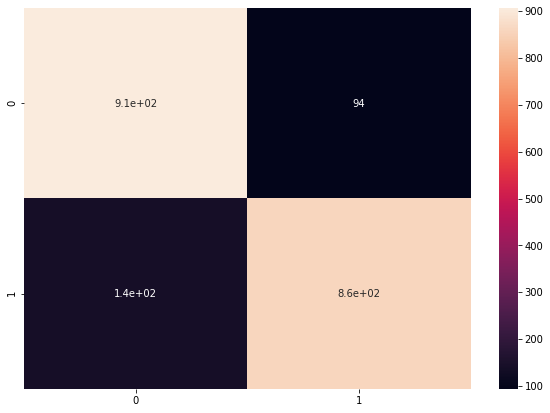

In [25]:
#confusion matrix for sparse bag of words
cm_sparse=confusion_matrix(sentiment_p_test + sentiment_n_test,lr_sparse_predict,labels=[1,0])

matrix_sparse = pd.DataFrame(cm_sparse, index = [i for i in "01"],
                  columns = [i for i in "01"])
plt.figure(figsize = (10,7))
sns.heatmap(matrix_sparse, annot=True)

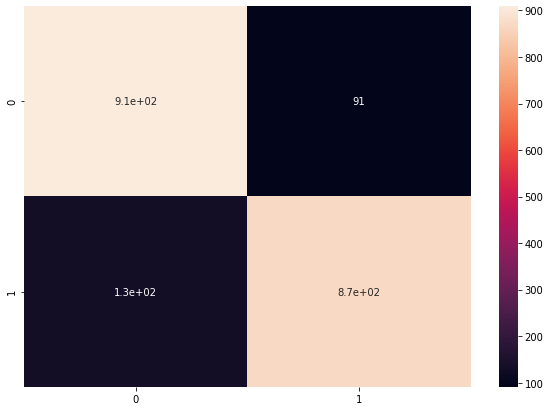

In [26]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(sentiment_p_test + sentiment_n_test,lr_bow_predict,labels=[1,0])

matrix_bow = pd.DataFrame(cm_bow, index = [i for i in "01"],
                  columns = [i for i in "01"])
plt.figure(figsize = (10,7))
sns.heatmap(matrix_bow, annot=True)

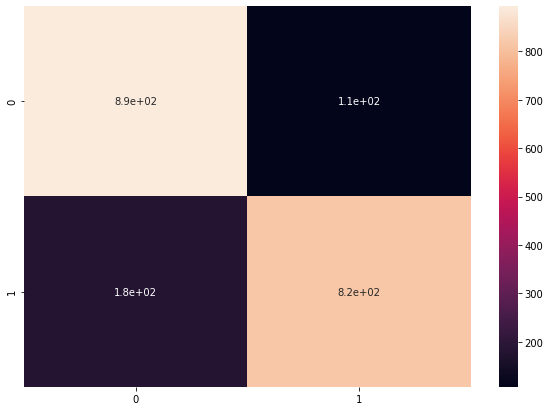

In [27]:
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(sentiment_p_test + sentiment_n_test,lr_tfidf_predict,labels=[1,0])

matrix_tfidf = pd.DataFrame(cm_tfidf, index = [i for i in "01"],
                  columns = [i for i in "01"])
plt.figure(figsize = (10,7))
sns.heatmap(matrix_tfidf, annot=True)

## Support Vector Machine with Stochastic Gradient Descent

In [44]:
# hyperparameter tuning for SVM 
svm = SGDClassifier()
alpha = [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
max_iter = [500] 
loss = ['hinge']
grid = dict(alpha=alpha,max_iter=max_iter,loss=loss)
# Here we start the grid search 
grid_search_1 = GridSearchCV(estimator=svm, param_grid=grid, n_jobs=-1, scoring='accuracy',error_score=0)
grid_search_2 = GridSearchCV(estimator=svm, param_grid=grid, n_jobs=-1, scoring='accuracy',error_score=0)
grid_search_3 = GridSearchCV(estimator=svm, param_grid=grid, n_jobs=-1, scoring='accuracy',error_score=0)

grid_result_1 = grid_search_1.fit(sparse_train_reviews, sentiment_p_train + sentiment_n_train)
print("Best Sparse: %f using %s" % (grid_result_1.best_score_, grid_result_1.best_params_))
grid_result_2 = grid_search_2.fit(cv_train_reviews, sentiment_p_train + sentiment_n_train)
print("Best BOW ngram: %f using %s" % (grid_result_2.best_score_, grid_result_2.best_params_))
grid_result_3 = grid_search_3.fit(tf_train_reviews, sentiment_p_train + sentiment_n_train)
print("Best tfidf: %f using %s" % (grid_result_3.best_score_, grid_result_3.best_params_))

Best Sparse: 0.873875 using {'alpha': 0.01, 'loss': 'hinge', 'max_iter': 500}
Best BOW ngram: 0.878875 using {'alpha': 0.01, 'loss': 'hinge', 'max_iter': 500}
Best tfidf: 0.867750 using {'alpha': 0.001, 'loss': 'hinge', 'max_iter': 500}


In [45]:
#training the linear svm
svm_1 = SGDClassifier(loss='hinge',max_iter=500,random_state=42, alpha=0.01)
svm_2 = SGDClassifier(loss='hinge',max_iter=500,random_state=42, alpha=0.01)
svm_3 = SGDClassifier(loss='hinge',max_iter=500,random_state=42, alpha=0.01)

#fitting the svm for sparse bag of words
svm_sparse=svm_1.fit(sparse_train_reviews,sentiment_p_train+sentiment_n_train)
print(svm_sparse)

#fitting the svm for bag of words
svm_bow=svm_2.fit(cv_train_reviews,sentiment_p_train+sentiment_n_train)
print(svm_bow)

#fitting the svm for tfidf features
svm_tfidf=svm_1.fit(tf_train_reviews,sentiment_p_train+sentiment_n_train)
print(svm_tfidf)

SGDClassifier(alpha=0.01, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=500, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
SGDClassifier(alpha=0.01, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=500, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
SGDClassifier(alpha=0.01, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=

In [46]:
#Predicting the model for sprase bag of words
svm_sparse_predict=svm_sparse.predict(sparse_test_reviews)

#Predicting the model for bag of words
svm_bow_predict=svm_bow.predict(cv_test_reviews)

#Predicting the model for tfidf features
svm_tfidf_predict=svm_tfidf.predict(tf_test_reviews)


In [47]:
# lets gets some reports on how we did 

#Accuracy score for sparse bag of words
svm_sparse_score=accuracy_score(sentiment_p_test + sentiment_n_test,svm_sparse_predict)
print("SVM with sprase BOW accuracy: ",svm_sparse_score)

#Classification report for sparse bag of words 
svm_sparse_report=classification_report(sentiment_p_test + sentiment_n_test, svm_sparse_predict,target_names=['Positive','Negative'])
print(svm_sparse_report)

#Accuracy score for bag of words
svm_bow_score=accuracy_score(sentiment_p_test + sentiment_n_test,svm_bow_predict)
print("SVM with BOW accuracy: ",svm_bow_score)

#Classification report for bag of words 
svm_bow_report=classification_report(sentiment_p_test + sentiment_n_test, svm_bow_predict,target_names=['Positive','Negative'])
print(svm_bow_report)

#Accuracy score for tfidf features
svm_tfidf_score=accuracy_score(sentiment_p_test + sentiment_n_test,svm_tfidf_predict)
print("SVM with TFIDF accuracy: ",svm_tfidf_score)

#Classification report for tfidf features
svm_tfidf_report=classification_report(sentiment_p_test + sentiment_n_test,svm_tfidf_predict,target_names=['Positive','Negative'])
print(svm_tfidf_report)

SVM with sprase BOW accuracy:  0.491
              precision    recall  f1-score   support

    Positive       0.49      0.31      0.38      1000
    Negative       0.49      0.68      0.57      1000

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.47      2000
weighted avg       0.49      0.49      0.47      2000

SVM with BOW accuracy:  0.8885
              precision    recall  f1-score   support

    Positive       0.90      0.87      0.89      1000
    Negative       0.88      0.90      0.89      1000

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000

SVM with TFIDF accuracy:  0.8235
              precision    recall  f1-score   support

    Positive       0.88      0.75      0.81      1000
    Negative       0.78      0.90      0.84      1000

    accuracy                           0.82      2000
   macro avg       0.83    

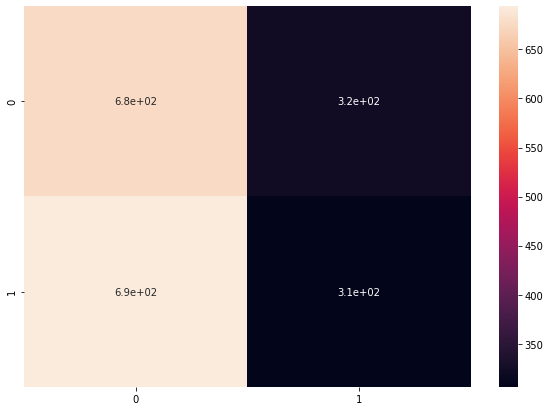

In [48]:
#confusion matrix for sparse bag of words
cm_sparse=confusion_matrix(sentiment_p_test + sentiment_n_test,svm_sparse_predict,labels=[1,0])

matrix_sparse = pd.DataFrame(cm_sparse, index = [i for i in "01"],
                  columns = [i for i in "01"])
plt.figure(figsize = (10,7))
sns.heatmap(matrix_sparse, annot=True)

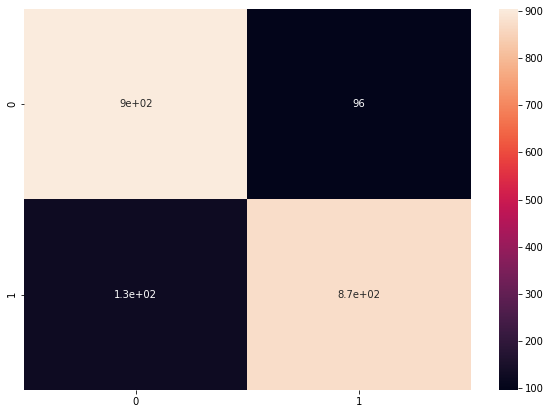

In [49]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(sentiment_p_test + sentiment_n_test,svm_bow_predict,labels=[1,0])

matrix_bow = pd.DataFrame(cm_bow, index = [i for i in "01"],
                  columns = [i for i in "01"])
plt.figure(figsize = (10,7))
sns.heatmap(matrix_bow, annot=True)

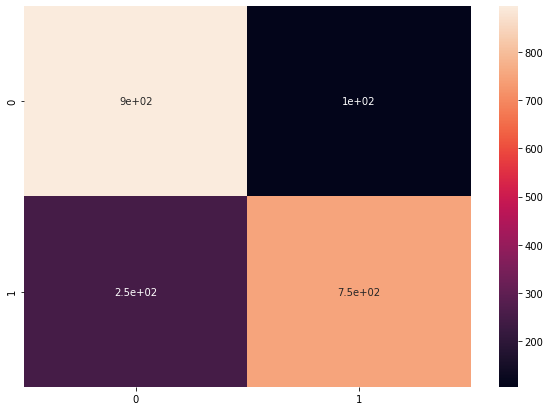

In [50]:
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(sentiment_p_test + sentiment_n_test,svm_tfidf_predict,labels=[1,0])

matrix_tfidf = pd.DataFrame(cm_tfidf, index = [i for i in "01"],
                  columns = [i for i in "01"])
plt.figure(figsize = (10,7))
sns.heatmap(matrix_tfidf, annot=True)

## Naives Bayes

In [28]:
# hyperparameter tuning for Naives Bayes
nb = MultinomialNB()
alpha = [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
grid = dict(alpha=alpha)
# Here we start the grid search 
grid_search_1 = GridSearchCV(estimator=nb, param_grid=grid, n_jobs=-1, scoring='accuracy',error_score=0)
grid_search_2 = GridSearchCV(estimator=nb, param_grid=grid, n_jobs=-1, scoring='accuracy',error_score=0)
grid_search_3 = GridSearchCV(estimator=nb, param_grid=grid, n_jobs=-1, scoring='accuracy',error_score=0)

grid_result_1 = grid_search_1.fit(sparse_train_reviews, sentiment_p_train + sentiment_n_train)
print("Best Sparse: %f using %s" % (grid_result_1.best_score_, grid_result_1.best_params_))
grid_result_2 = grid_search_2.fit(cv_train_reviews, sentiment_p_train + sentiment_n_train)
print("Best BOW ngram: %f using %s" % (grid_result_2.best_score_, grid_result_2.best_params_))
grid_result_3 = grid_search_3.fit(tf_train_reviews, sentiment_p_train + sentiment_n_train)
print("Best tfidf: %f using %s" % (grid_result_3.best_score_, grid_result_3.best_params_))


Best Sparse: 0.867375 using {'alpha': 1.0}
Best BOW ngram: 0.885000 using {'alpha': 0.1}
Best tfidf: 0.892000 using {'alpha': 0.1}


In [29]:
#training the Naives Bayes Model
nbm_1 = MultinomialNB(alpha=1)
nbm_2 = MultinomialNB(alpha=0.1)
nbm_3 = MultinomialNB(alpha=0.1)

#fitting the NBM for sparse bag of words
nbm_sparse = nbm_1.fit(sparse_train_reviews,sentiment_p_train+sentiment_n_train)
print(nbm_sparse)

#fitting the NBM for bag of words
nbm_bow = nbm_2.fit(cv_train_reviews,sentiment_p_train+sentiment_n_train)
print(nbm_bow)

#fitting the NBM for tfidf features
nbm_tfidf = nbm_3.fit(tf_train_reviews,sentiment_p_train+sentiment_n_train)
print(nbm_tfidf)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)
MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)
MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)


In [30]:
#Predicting the model for bag of words
nbm_sparse_predict=nbm_sparse.predict(sparse_test_reviews)

#Predicting the model for bag of words
nbm_bow_predict=nbm_bow.predict(cv_test_reviews)

#Predicting the model for tfidf features
nbm_tfidf_predict=nbm_tfidf.predict(tf_test_reviews)

In [31]:
# lets gets some reports on how we did 

#Accuracy score for bag of words
nbm_sparse_score=accuracy_score(sentiment_p_test + sentiment_n_test,nbm_sparse_predict)
print("Naives Bayes with sparse BOW accuracy: ",nbm_sparse_score)

#Classification report for bag of words 
nbm_sparse_report=classification_report(sentiment_p_test + sentiment_n_test, nbm_sparse_predict,target_names=['Positive','Negative'])
print(nbm_sparse_report)

#Accuracy score for bag of words
nbm_bow_score=accuracy_score(sentiment_p_test + sentiment_n_test,nbm_bow_predict)
print("Naives Bayes with BOW accuracy: ",nbm_bow_score)

#Classification report for bag of words 
nbm_bow_report=classification_report(sentiment_p_test + sentiment_n_test, nbm_bow_predict,target_names=['Positive','Negative'])
print(nbm_bow_report)

#Accuracy score for tfidf features
nbm_tfidf_score=accuracy_score(sentiment_p_test + sentiment_n_test,nbm_tfidf_predict)
print("Naives Bayes with TFIDF accuracy: ",nbm_tfidf_score)

#Classification report for tfidf features
nbm_tfidf_report=classification_report(sentiment_p_test + sentiment_n_test,nbm_tfidf_predict,target_names=['Positive','Negative'])
print(nbm_tfidf_report)

Naives Bayes with sparse BOW accuracy:  0.873
              precision    recall  f1-score   support

    Positive       0.87      0.88      0.87      1000
    Negative       0.88      0.86      0.87      1000

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000

Naives Bayes with BOW accuracy:  0.893
              precision    recall  f1-score   support

    Positive       0.90      0.89      0.89      1000
    Negative       0.89      0.90      0.89      1000

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000

Naives Bayes with TFIDF accuracy:  0.8995
              precision    recall  f1-score   support

    Positive       0.92      0.88      0.90      1000
    Negative       0.88      0.92      0.90      1000

    accuracy                           0.90      2000
 

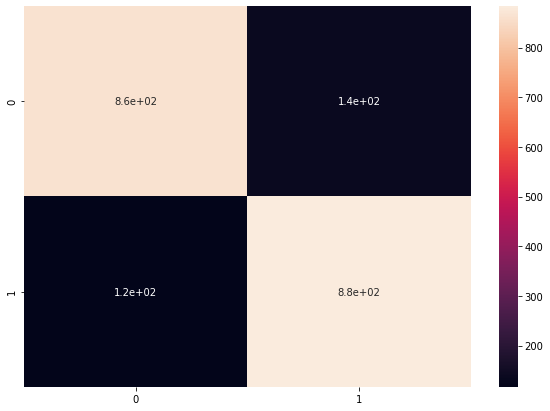

In [32]:
#confusion matrix for sparse bag of words
cm_sparse = confusion_matrix(sentiment_p_test + sentiment_n_test,nbm_sparse_predict,labels=[1,0])

matrix_sparse = pd.DataFrame(cm_sparse, index = [i for i in "01"],
                  columns = [i for i in "01"])
plt.figure(figsize = (10,7))
sns.heatmap(matrix_sparse, annot=True)

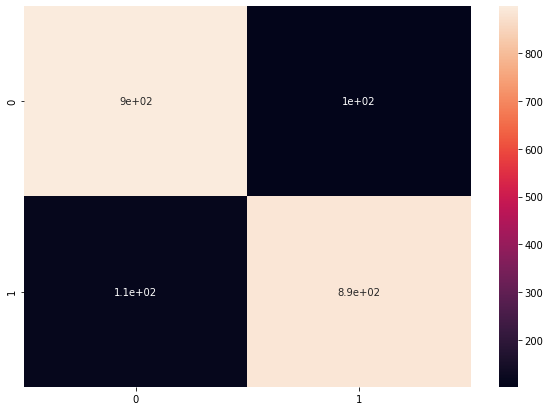

In [33]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(sentiment_p_test + sentiment_n_test,nbm_bow_predict,labels=[1,0])

matrix_bow = pd.DataFrame(cm_bow, index = [i for i in "01"],
                  columns = [i for i in "01"])
plt.figure(figsize = (10,7))
sns.heatmap(matrix_bow, annot=True)

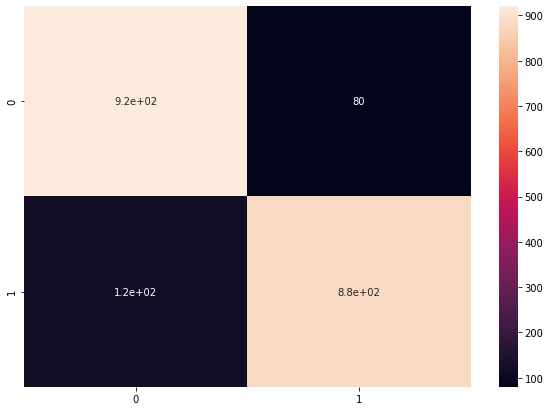

In [34]:
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(sentiment_p_test + sentiment_n_test,nbm_tfidf_predict,labels=[1,0])

matrix_tfidf = pd.DataFrame(cm_tfidf, index = [i for i in "01"],
                  columns = [i for i in "01"])
plt.figure(figsize = (10,7))
sns.heatmap(matrix_tfidf, annot=True)

## Random Forest Classifier

In [ ]:
# hyperparameter tuning for Random Forest
rf = RandomForestClassifier()
n_estimators = [10, 100, 250]
max_features = [1, 5, 10, 25, 50]
# Here we start the grid search
grid = dict(n_estimators=n_estimators,max_features=max_features) 
grid_search_1 = GridSearchCV(estimator=rf, param_grid=grid, n_jobs=-1, scoring='accuracy',error_score=0)
grid_search_2 = GridSearchCV(estimator=rf, param_grid=grid, n_jobs=-1, scoring='accuracy',error_score=0)
grid_search_3 = GridSearchCV(estimator=rf, param_grid=grid, n_jobs=-1, scoring='accuracy',error_score=0)

# Print Results
grid_result_1 = grid_search_1.fit(sparse_train_reviews, sentiment_p_train + sentiment_n_train)
print("Best Sparse: %f using %s" % (grid_result_1.best_score_, grid_result_1.best_params_))
grid_result_2 = grid_search_2.fit(cv_train_reviews, sentiment_p_train + sentiment_n_train)
print("Best BOW ngram: %f using %s" % (grid_result_2.best_score_, grid_result_2.best_params_))
grid_result_3 = grid_search_3.fit(tf_train_reviews, sentiment_p_train + sentiment_n_train)
print("Best tfidf: %f using %s" % (grid_result_3.best_score_, grid_result_3.best_params_))

In [38]:
#training the Random Forest Model
rf_1 = RandomForestClassifier(n_estimators = 100, max_depth=50)
rf_2 = RandomForestClassifier(n_estimators = 100, max_depth=50)
rf_3 = RandomForestClassifier(n_estimators = 100, max_depth=50)


#fitting the random forest for sparse bag of words
rf_sparse = rf_1.fit(sparse_train_reviews,sentiment_p_train+sentiment_n_train)
print(rf_sparse)

#fitting the random forest for bag of words
rf_bow = rf_2.fit(cv_train_reviews,sentiment_p_train+sentiment_n_train)
print(rf_bow)

#fitting the random forest for tfidf features
rf_tfidf = rf_3.fit(tf_train_reviews,sentiment_p_train+sentiment_n_train)
print(rf_tfidf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None

In [39]:
#Predicting the model for bag of words
rf_sparse_predict=  rf_sparse.predict(cv_test_reviews)

#Predicting the model for bag of words
rf_bow_predict=  rf_bow.predict(cv_test_reviews)

#Predicting the model for tfidf features
rf_tfidf_predict = rf_tfidf.predict(tf_test_reviews)

In [40]:
# lets gets some reports on how we did 

#Accuracy score for sparse bag of words
rf_sparse_score=accuracy_score(sentiment_p_test + sentiment_n_test,rf_sparse_predict)
print("Naives Bayes with BOW accuracy: ",rf_sparse_score)

#Classification report for sparse bag of words 
rf_sparse_report=classification_report(sentiment_p_test + sentiment_n_test, rf_sparse_predict,target_names=['Positive','Negative'])
print(rf_sparse_report)


#Accuracy score for bag of words
rf_bow_score=accuracy_score(sentiment_p_test + sentiment_n_test,rf_bow_predict)
print("Naives Bayes with BOW accuracy: ",rf_bow_score)

#Classification report for bag of words 
rf_bow_report=classification_report(sentiment_p_test + sentiment_n_test, rf_bow_predict,target_names=['Positive','Negative'])
print(rf_bow_report)

#Accuracy score for tfidf features
rf_tfidf_score=accuracy_score(sentiment_p_test + sentiment_n_test,rf_tfidf_predict)
print("Naives Bayes with TFIDF accuracy: ",rf_tfidf_score)

#Classification report for tfidf features
rf_tfidf_report=classification_report(sentiment_p_test + sentiment_n_test,rf_tfidf_predict,target_names=['Positive','Negative'])
print(rf_tfidf_report)

Naives Bayes with BOW accuracy:  0.518
              precision    recall  f1-score   support

    Positive       0.54      0.23      0.33      1000
    Negative       0.51      0.80      0.62      1000

    accuracy                           0.52      2000
   macro avg       0.53      0.52      0.48      2000
weighted avg       0.53      0.52      0.48      2000

Naives Bayes with BOW accuracy:  0.8495
              precision    recall  f1-score   support

    Positive       0.87      0.82      0.85      1000
    Negative       0.83      0.88      0.85      1000

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000

Naives Bayes with TFIDF accuracy:  0.8485
              precision    recall  f1-score   support

    Positive       0.85      0.84      0.85      1000
    Negative       0.84      0.85      0.85      1000

    accuracy                           0.85      2000
   macr

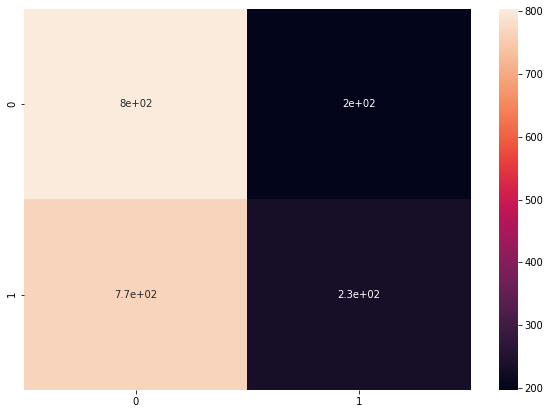

In [41]:
#confusion matrix for sparse bag of words
cm_sparse=confusion_matrix(sentiment_p_test + sentiment_n_test,rf_sparse_predict,labels=[1,0])

matrix_sparse = pd.DataFrame(cm_sparse, index = [i for i in "01"],
                  columns = [i for i in "01"])
plt.figure(figsize = (10,7))
sns.heatmap(matrix_sparse, annot=True)

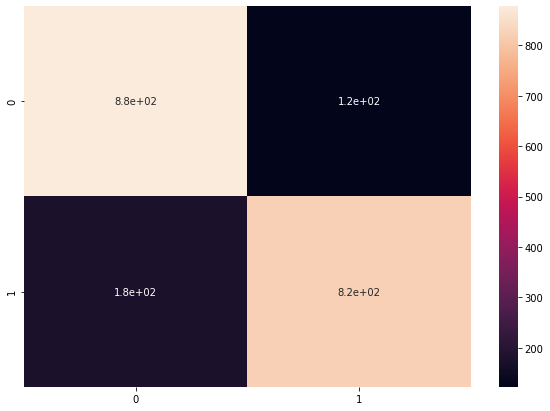

In [42]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(sentiment_p_test + sentiment_n_test,rf_bow_predict,labels=[1,0])

matrix_bow = pd.DataFrame(cm_bow, index = [i for i in "01"],
                  columns = [i for i in "01"])
plt.figure(figsize = (10,7))
sns.heatmap(matrix_bow, annot=True)

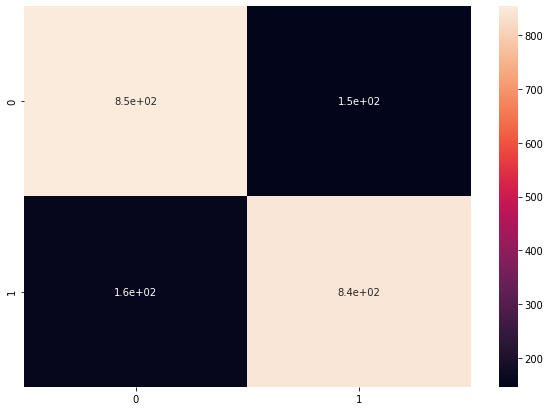

In [43]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(sentiment_p_test + sentiment_n_test,rf_tfidf_predict,labels=[1,0])

matrix_bow = pd.DataFrame(cm_bow, index = [i for i in "01"],
                  columns = [i for i in "01"])
plt.figure(figsize = (10,7))
sns.heatmap(matrix_bow, annot=True)

## Nueral Net


In [35]:
from keras.preprocessing.text import Tokenizer

# Here we must turn our reviews into tokens for our model to run 
max_features = 600000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(review_p_train + review_n_train)
list_tokenized_train = tokenizer.texts_to_sequences(review_p_train + review_n_train)

# here we pad the tokens to ensure that the reviewis all are the same length in order to pass it into the nueral net
maxlen = 100
x = pad_sequences(list_tokenized_train, maxlen=maxlen)
y = np.array(sentiment_p_train + sentiment_n_train)

# just do the same for test reviews 
y_test = np.array(sentiment_p_test + sentiment_n_test)
list_tokenized_test = tokenizer.texts_to_sequences(review_p_test + review_n_test)
x_test = pad_sequences(list_tokenized_test, maxlen=maxlen)

# define the nueral net
embed_size =  256
model = Sequential()
model.add(Embedding(max_features, embed_size))
model.add(Bidirectional(LSTM(32, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.03))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# actually training the NN
model.fit(x,y, batch_size=100, epochs=3, validation_split=0.2)

Epoch 1/3
64/64 [==============================] - 126s 2s/step - loss: 0.6569 - accuracy: 0.6348 - val_loss: 0.8466 - val_accuracy: 0.7200
Epoch 2/3
64/64 [==============================] - 114s 2s/step - loss: 0.2848 - accuracy: 0.9099 - val_loss: 0.4345 - val_accuracy: 0.8256
Epoch 3/3
64/64 [==============================] - 115s 2s/step - loss: 0.0775 - accuracy: 0.9756 - val_loss: 0.5526 - val_accuracy: 0.8175


In [36]:
# testing our model 
prediction = model.predict(x_test)
y_pred = (prediction > 0.5)
print('F1 score: {0}'.format(f1_score(y_pred, y_test)))
confusion_matrix(y_pred, y_test)

F1 score: 0.8710900473933649


array([[809,  81],
       [191, 919]])

## Let's Have Some Fun


In [ ]:
import requests
from bs4 import BeautifulSoup

def getSoup(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    return soup

In [ ]:
def getRating(movie):
  query = movie.replace(" ", "+")

  url = 'https://www.imdb.com/search/title/?title=' + query

  # get the soup object for main api url
  movies_soup = getSoup(url)
  # find all a-tags with class:None
  movie_tags = movies_soup.find_all('a', attrs={'class': None})

  # filter the a-tags to get just the titles
  movie_tags = [tag.attrs['href'] for tag in movie_tags 
                if tag.attrs['href'].startswith('/title') & tag.attrs['href'].endswith('/')]

  # remove duplicate links
  movie_tags = list(dict.fromkeys(movie_tags))

  movie_tags[0]
  # print(movie_tags[0])

  # movie links
  base_url = "https://www.imdb.com"
  movie_link = base_url + movie_tags[0] + 'reviews'
  movie_soup = getSoup(movie_link)

  movie_review_tags = movie_soup.find_all('a', attrs={'class':'title'})
  movie_reviews = []
  for tag in movie_review_tags: 
    link = "https://www.imdb.com" + tag['href']
    review_soup = getSoup(link)
    tag = review_soup.find('div', attrs={'class': 'text show-more__control'})
    movie_reviews.append(tag.getText())

  movie_reviews

  reviews = list(map(denoise_text, movie_reviews))
  reviews = list(map(stemmer, reviews))
  reviews = list(map(remove_stopwords, reviews))

  vectorized_reviews = tf.transform(reviews)
  predictions=nbm_tfidf.predict(vectorized_reviews)
  preds = np.array(predictions)
  accuracy = (np.count_nonzero(preds==1))/len(predictions)
  accuracy
  return accuracy


In [ ]:
def runInteractive():
  tries = 0
  while tries < 4:
    movie = input("What movie do you want to know the rating for?: \t")
    try:
      rating = getRating(movie)
      print(movie+ " has a rating of: " + str(round(rating*10,2)) + "/10")
    except:
      print("Sorry the movie could not be found. Please try again or try another movie.")
    tries += 1
  print("Hope you enjoyed this!")

In [ ]:
runInteractive()